In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
traj = pd.read_csv("../data/traj.csv")
image = np.load("../data/image.npy")
A = np.load("../data/A.npy")

In [3]:
traj.t -= traj.t.min()

In [4]:
def create_diag(size, n=0): 
    x = np.ones(size)
    A = np.zeros((size, size))
    for i in range(-n, n+1):
        if i == 0:
            a = np.diag(x, i)
        elif i < 0:
            a = np.diag(x[:i], i)
        else:
            a = np.diag(x[i:], i)
        A = A + a
        
    A = A / A.sum(axis=0, keepdims=True)
    
    return A

In [5]:
traj.head()

,x,y,z,t,pred,i
0,61661.875502,134296.655761,57883.138260,0,0,1
1,61895.245035,133642.625806,55568.056865,10,0,1
2,62502.707049,132745.201293,53022.983638,20,0,1
3,62863.222550,131473.286796,50947.133795,30,0,1
4,63084.263229,129954.971787,49934.379416,40,0,1


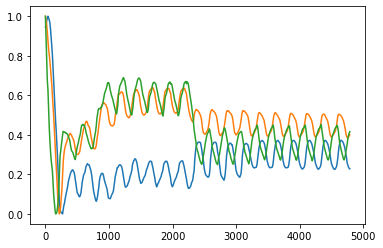

In [6]:
for c in "xyz":
    x = traj[c]
    x = (x - x.min()) / np.ptp(x)
    plt.plot(traj.t, x)

In [7]:
image /= image.max()

In [8]:
M = create_diag(len(A), 4)
pred = (A * M).sum(axis=0)

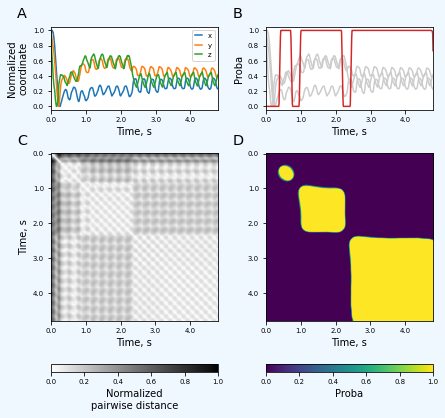

In [14]:
height_percents = [0.03, 0.6, 0.3]
height_percents = np.array(height_percents) / np.sum(height_percents)
space_w = 0.1
space_h = 0.1

width = (1 - space_w * 3) / 2
heights = [(1 - space_h * 4) * h for h in height_percents]

aspect = heights[1] / width

fig_height = 6
fig_width = fig_height * aspect

fig = plt.figure(
    figsize=(fig_width, fig_height),
    facecolor="aliceblue"
)

bottom = space_h

for i in range(len(heights)):
    axes_row = []
    for j in range(2):
        
        left = space_w + (width + space_w) * j
        width = width
        
        height = heights[i]
        
        pos = [left, bottom, width, height]
        plt.axes(pos)
                
    bottom += height + space_h

axes = np.array(fig.axes).reshape(-1, 2)

######################

plt.sca(axes[2, 0])
for c in "xyz":
    x = traj[c]
    x = (x - x.min()) / np.ptp(x)
    plt.plot(traj.t, x, label=c)
plt.legend(
    loc="upper right",
    ncol=1,
    fontsize="x-small",
    handlelength=1
)
plt.ylabel("Normalized\ncoordinate")
    
plt.sca(axes[2, 1])
for c in "xyz":
    x = traj[c]
    x = (x - x.min()) / np.ptp(x)
    plt.plot(traj.t, x, color="0.8")
plt.plot(traj.t, pred, color="C3")
plt.ylabel("Proba")

t_max = traj.t.max()

for ax in axes[2].flatten():
    plt.sca(ax)
    plt.xticks(
        np.arange(0, t_max, 1000),
        np.arange(0, t_max, 1000) / 1000,
        # size="x-small"
    )
    plt.xlim(traj.t.min(), traj.t.max())
    plt.xlabel("Time, s")
      
ims = axes[1, 1].imshow(A)
plt.colorbar(
    ims,
    cax=axes[0, 1],
    orientation="horizontal",
    ticks=np.linspace(0, 1, 6),
) 

plt.sca(axes[0, 1])
plt.xlabel("Proba")
plt.xlim(0, 1)
plt.xticks(np.linspace(0, 1, 6), size="x-small")


ims = axes[1, 0].imshow(image, cmap=cm.grayC)
plt.colorbar(
    ims,
    cax=axes[0, 0],
    orientation="horizontal",
    ticks=np.linspace(0, 1, 6),
) 

plt.sca(axes[0, 0])
plt.xlabel("Normalized\npairwise distance")
plt.xlim(0, 1)
plt.xticks(np.linspace(0, 1, 6), size="x-small")

for ax in axes[1].flatten():
    plt.sca(ax)
    plt.xticks(
        np.arange(0, len(A), 100),
        np.arange(0, len(A), 100) / 100,
        size="x-small"
    )
    plt.yticks(
        np.arange(0, len(A), 100),
        np.arange(0, len(A), 100) / 100,
        size="x-small"
    )
    plt.xlabel("Time, s")
    
plt.sca(axes[1, 0])
plt.ylabel("Time, s")


letters = "ABCD"
for ax, letter in zip(axes[1:][::-1].flatten(), letters):
    ax.tick_params(axis="x", labelsize="x-small")
    ax.tick_params(axis="y", labelsize="x-small")
    
    letter_margin_x = 0.07
    letter_margin_y = 0.02
    letter_params = dict(
        weight="normal",
        size="x-large"
    )
    
    pos = ax.get_position()

    fig.text(
        pos.xmin - letter_margin_x,
        pos.ymax + letter_margin_y,
        letter,
        **letter_params
    )

plt.savefig(
    "../images/illustation.png",
    facecolor="white",
    bbox_inches="tight",
    dpi=300
)

# Idea

In [35]:
from scipy.ndimage import gaussian_filter1d, gaussian_filter

In [98]:
def normalize(x):
    return (x - x.min()) / np.ptp(x)

In [102]:
noise = 0.2

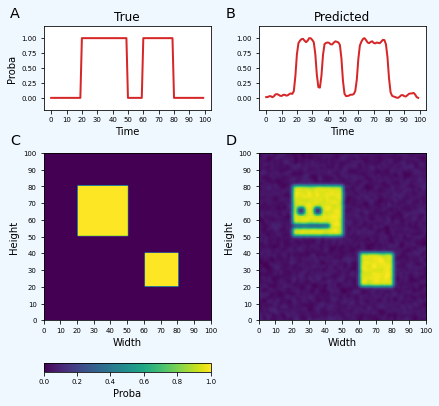

In [113]:
height_percents = [0.03, 0.6, 0.3]
height_percents = np.array(height_percents) / np.sum(height_percents)
space_w = 0.1
space_h = 0.1

width = (1 - space_w * 3) / 2
heights = [(1 - space_h * 4) * h for h in height_percents]

aspect = heights[1] / width

fig_height = 6
fig_width = fig_height * aspect

fig = plt.figure(
    figsize=(fig_width, fig_height),
    facecolor="aliceblue",
)

bottom = space_h

for i in range(len(heights)):
    axes_row = []
    for j in range(2):
        
        left = space_w + (width + space_w) * j
        width = width
        
        height = heights[i]
        
        pos = [left, bottom, width, height]
        
        # if i == 0 and j == 0:
        #     continue
            
        plt.axes(pos)
                
    bottom += height + space_h

axes = np.array(fig.axes).reshape(-1, 2)

#############

true_1d = np.zeros(100)

i1_min, i1_max = 20, 50
i2_min, i2_max = 60, 80

j1_min, j1_max = 33, 37

σ = 1

true_1d[i1_min: i1_max] = 1
true_1d[i2_min: i2_max] = 1

pred_1d = true_1d.copy()
pred_1d[j1_min: j1_max] = 0.

pred_1d += np.random.rand(*pred_1d.shape) * noise

pred_1d = gaussian_filter1d(pred_1d, σ)
pred_1d = normalize(pred_1d)

plt.sca(axes[2, 0])
plt.plot(true_1d, "C3", lw=2)
plt.ylim(-0.2, 1.2)
plt.title("True")
plt.ylabel("Proba")
plt.xticks(np.arange(0, 101, 10))
plt.xlabel("Time")

plt.sca(axes[2, 1])
# plt.plot(true_1d, color="0.5", lw=2)
plt.plot(pred_1d, "C3", lw=2)
plt.ylim(-0.2, 1.2)
# plt.yticks([])
plt.title("Predicted")
plt.xticks(np.arange(0, 101, 10))
plt.xlabel("Time")

##############

true_2d = np.zeros((100, 100))
true_2d[i1_min: i1_max, i1_min: i1_max] = 1
true_2d[i2_min: i2_max, i2_min: i2_max] = 1

pred_2d = true_2d.copy()

pred_2d[j1_min: j1_max, j1_min: j1_max] = 0
pred_2d[j1_min: j1_max, j1_min-10: j1_max-10] = 0



pred_2d[j1_min + 10: j1_min + 12, j1_min - 20: j1_max + 5] = 0

# jm = (i2_min + i2_max) // 2
# k = 5
# pred_2d[jm: jm + k, i2_max - k: i2_max] = 0

pred_2d += np.random.rand(*pred_2d.shape) * noise

pred_2d = gaussian_filter(pred_2d, σ)
pred_2d = normalize(pred_2d)


plt.sca(axes[1, 0])
axes[0, 1].tick_params(axis="x", labelsize="x-small")
ims = plt.imshow(true_2d, extent=(0, 100, 0, 100))
plt.colorbar(
    ims,
    cax=axes[0, 0],
    orientation="horizontal",
    ticks=np.linspace(0, 1, 6),
) 
plt.xticks(np.arange(0, 101, 10))
plt.yticks(np.arange(0, 101, 10))
plt.xlabel("Width")
plt.ylabel("Height")


ax_colorbar = axes[0, 0]
ax_colorbar.tick_params(axis="x", labelsize="x-small")
ax_colorbar.set_xlabel("Proba")

plt.sca(axes[1, 1])
plt.imshow(pred_2d, extent=(0, 100, 0, 100))
# plt.colorbar(
#     ims,
#     cax=ax_colorbar,
#     orientation="horizontal",
#     ticks=np.linspace(0, 1, 6),
# ) 
plt.xticks(np.arange(0, 101, 10))
plt.yticks(np.arange(0, 101, 10))
plt.xlabel("Width")
plt.ylabel("Height")

axes[0, 1].remove()


if False:
    plt.plot(
        [i1_min, i1_max, i1_max, i1_min, i1_min],
        [i1_max, i1_max, i1_min, i1_min, i1_max],
        ":w"
    )

    plt.plot(
        [i2_min, i2_max, i2_max, i2_min, i2_min],
        [i2_max, i2_max, i2_min, i2_min, i2_max],
        ":w"
    )
    
    
letters = "ABCD"
for ax, letter in zip(axes[1:][::-1].flatten(), letters):
    ax.tick_params(axis="x", labelsize="x-small")
    ax.tick_params(axis="y", labelsize="x-small")
    
    letter_margin_x = 0.07
    letter_margin_y = 0.02
    letter_params = dict(
        weight="normal",
        size="x-large"
    )
    
    pos = ax.get_position()

    fig.text(
        pos.xmin - letter_margin_x,
        pos.ymax + letter_margin_y,
        letter,
        **letter_params
    )
    

# plt.savefig(
#     "../images/explanation.png",
#     facecolor="white",
#     bbox_inches="tight",
#     dpi=300
# )